In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import preprocessing
from collections import defaultdict, Counter
from nltk.util import ngrams
import collections
import nltk
import warnings
import xgboost as xgb
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.metrics import  precision_score, recall_score
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab import files
from tqdm import tqdm
tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
uploaded = files.upload()

Saving home_assignment_data.parquet to home_assignment_data.parquet


In [5]:
df = pd.read_parquet('home_assignment_data.parquet')
df = df[df['days_since_install'].notnull()]
len(df)

9991

In [6]:
df['convergance'] = 100 * (df['clicks'] / df['impressions'])
df['feature_types'] = df['feature_types'].apply(lambda features: [feature.strip().lower() for feature in features])
df['unique_feature_types'] = df['feature_types'].apply(lambda features: list(set(features)))
df['language_clean'] = df['language'].apply(lambda language: language.split('-')[0])
df['number_of_feature_types'] = df['feature_types'].apply(len)
df['number_of_unique_feature_types'] = df['unique_feature_types'].apply(len)

In [7]:
train_df, test_df = train_test_split(df, test_size = 0.2)

len(train_df), len(test_df)

(7992, 1999)

In [8]:
UNK_FEATURTE = 'FEATURE_UNK'
FEATURE_MIN_TEMPLATES = 5
UNK_FEATURTE

'FEATURE_UNK'

In [9]:
all_unique_features = {feature for features in train_df['unique_feature_types'].tolist() for feature in features}
len(all_unique_features) 

41

In [10]:
feature_types_counter = Counter([feature for features in train_df['unique_feature_types'].tolist() for feature in features])
valid_features = {feature for (feature, count) in  feature_types_counter.items() if count > FEATURE_MIN_TEMPLATES}
valid_features.add(UNK_FEATURTE)
len(valid_features)

33

In [11]:
features_lists = train_df['feature_types'].tolist()
features_lists = [['start']  + f + ['end'] for f in features_lists]

feature_counts = Counter()

for features in features_lists:
    feature_counts.update(nltk.ngrams(features, 1))
    feature_counts.update(nltk.ngrams(features, 2))

In [12]:
language_count = df.groupby(['language_clean']).size().to_frame('size').reset_index()
valid_languages = set(language_count[language_count['size'] > 50]['language_clean'])
UNK_LANGUAGE = 'UNK_LANGUAGE'
valid_languages.add(UNK_LANGUAGE)
len(valid_languages), len(pd.unique(df['language_clean']))

(14, 45)

In [13]:
country_count = df.groupby(['country']).size().to_frame('size').reset_index()
valid_countries = set(country_count[country_count['size'] > 50]['country'])
UNK_COUNTRY = 'UNK_COUNTRY'
valid_countries.add(UNK_COUNTRY)
len(valid_countries), len(pd.unique(df['country']))

(29, 145)

In [14]:
train_df['country'] = train_df['country'].apply(lambda country: country if country in valid_countries else UNK_COUNTRY)
train_df['language_clean'] = train_df['language_clean'].apply(lambda language_clean: language_clean if language_clean in valid_languages else UNK_LANGUAGE)

test_df['country'] = test_df['country'].apply(lambda country: country if country in valid_countries else UNK_COUNTRY)
test_df['language_clean'] = test_df['language_clean'].apply(lambda language_clean: language_clean if language_clean in valid_languages else UNK_LANGUAGE)


In [15]:
country_encoder = preprocessing.LabelEncoder()
language_clean_encoder = preprocessing.LabelEncoder()
country_encoder.fit(train_df['country'])
language_clean_encoder.fit(train_df['language_clean'])
pd.unique(train_df['language_clean']), pd.unique(train_df['country'])

(array(['en', 'es', 'ru', 'it', 'fr', 'pt', 'ar', 'de', 'uk', 'tr',
        'UNK_LANGUAGE', 'sv', 'pl', 'nl'], dtype=object),
 array(['US', 'UNK_COUNTRY', 'AU', 'JP', 'CA', 'KZ', 'RU', 'IT', 'FR',
        'BR', 'BY', 'SA', 'GB', 'CH', 'EG', 'KW', 'IN', 'IQ', 'IL', 'UA',
        'TR', 'SE', 'DE', 'AE', 'ES', 'PL', 'CO', 'MX', 'NL'], dtype=object))

In [16]:
def count_feature(feature_types):
    feature_to_count = defaultdict(lambda: 0.)
    
    for feature in feature_types:
        feature_to_count[feature] += 1
    return feature_to_count

def get_feature_duration(feature_types, features_duration):
    feature_to_duration = defaultdict(lambda: 0.)
    
    for (feature, duration) in zip(feature_types, features_duration):
        feature_to_duration[feature] += duration
    return feature_to_duration

def get_feature_min_start_time(feature_types, features_start_times):
    feature_to_min_start_time = defaultdict(lambda: -1)
    
    for (feature, start_time) in zip(feature_types, features_start_times):
        
        if feature in feature_to_min_start_time:
            continue 
            
        feature_to_min_start_time[feature] = start_time
        
    return feature_to_min_start_time


def get_feature_min_max_median_duration(durations, features, target_feature):
    durations = [duration for (feature, duration) in  zip(features ,durations) if feature == target_feature] 
    
    if len(durations) == 0:
        return pd.Series([-1, -1, -1])
    
    
    return pd.Series([np.min(durations), np.max(durations), np.median(durations)])
    


def get_label(convergence):
    
    if convergence < 1/300:
        return 0 
    
    return 1



def create_features(dataset):
    
    dataset = dataset.copy(True)
    
    dataset['feature_types_clean'] = dataset['feature_types'].apply(lambda features: [UNK_FEATURTE if feature not in valid_features else feature for feature in features])
    
    dataset['number_of_unk_features'] = dataset['feature_types'].apply(lambda features: len([1 for feature in features if feature not in valid_features ]))
    
    dataset['feature_count'] = dataset['feature_types_clean'].apply(count_feature)
    dataset['features_to_duration'] = dataset.apply(lambda r: get_feature_duration(r['feature_types_clean'], r['feature_durations']), axis=1)
    dataset['features_to_start_time'] = dataset.apply(lambda r: get_feature_min_start_time(r['feature_types_clean'], r['start_times']), axis=1)
    dataset['transition_to_duration'] = dataset['transitions_count']/dataset['duration']
    
    dataset['duration_to_unique_features'] = dataset['duration']/dataset['number_of_unique_feature_types']
    dataset['duration_to_features'] = dataset['duration']/dataset['number_of_feature_types']
    
    for feature in valid_features:
        dataset[f'{feature}_duration'] = dataset['features_to_duration'].apply(lambda features_to_duration: features_to_duration[feature])
        dataset[f'{feature}_start_time'] = dataset['features_to_start_time'].apply(lambda features_to_start_time: features_to_start_time[feature])
        dataset[f'{feature}_count'] = dataset['feature_count'].apply(lambda feature_count: feature_count[feature])
    
   
    for feature in valid_features:
        dataset[[f'{feature}_min', f'{feature}_max', f'{feature}_median']] =  dataset.apply(lambda r: get_feature_min_max_median_duration(r['feature_durations'], r['feature_types_clean'], feature) , axis=1) 
 
        
    dataset['post_hour'] = dataset['post_timestamp'].apply(lambda pt: pt.hour)
    dataset['post_month'] = dataset['post_timestamp'].apply(lambda pt: pt.month)
    dataset['post_weekday'] = dataset['post_timestamp'].apply(lambda pt: pt.weekday())
    dataset['country'] = country_encoder.transform(dataset['country'])
    dataset['language_clean'] = language_clean_encoder.transform(dataset['language_clean'])
    
    y = dataset['convergance'].tolist() #apply(get_label).tolist()
    
    dataset.drop(columns = ['feature_count', 'features_to_duration', 'features_to_start_time',
                           'post_timestamp', 'feature_types',
                            'start_times', 'feature_durations',
                            'impressions', 'clicks',
                           'convergance', 'unique_feature_types',
                           'language', 'feature_types_clean'], inplace = True)
        
    return dataset, y
        
    

In [17]:
train_features, train_y = create_features(train_df)
test_features, test_y = create_features(test_df)

In [18]:

numerical_features_cols = ['days_since_install', 'followers_count', 'duration', 'height', 'width', 'replaceable_count',
                       'transitions_count', 'number_of_feature_types', 'number_of_unique_feature_types',
                       'number_of_unk_features', 'transition_to_duration', 'duration_to_unique_features',
                       'duration_to_features', 'clip_duration',
 'clip_start_time',
 'clip_count',
 'evdcrtinputmodel_duration',
 'evdcrtinputmodel_start_time',
 'evdcrtinputmodel_count',
 'evdfilmgraininputmodel_duration',
 'evdfilmgraininputmodel_start_time',
 'evdfilmgraininputmodel_count',
 'pixelate_duration',
 'pixelate_start_time',
 'pixelate_count',
 'sound effect_duration',
 'sound effect_start_time',
 'sound effect_count',
 'fxlayer_duration',
 'fxlayer_start_time',
 'fxlayer_count',
 'mixer_duration',
 'mixer_start_time',
 'mixer_count',
 'fisheye_duration',
 'fisheye_start_time',
 'fisheye_count',
 'kaleidoscope_duration',
 'kaleidoscope_start_time',
 'kaleidoscope_count',
 'evdstrobeinputmodel_duration',
 'evdstrobeinputmodel_start_time',
 'evdstrobeinputmodel_count',
 'colorsplash_duration',
 'colorsplash_start_time',
 'colorsplash_count',
 'music_duration',
 'music_start_time',
 'music_count',
 'sticker_duration',
 'sticker_start_time',
 'sticker_count',
 'evdfilterslayerinputmodel_duration',
 'evdfilterslayerinputmodel_start_time',
 'evdfilterslayerinputmodel_count',
 'evdadjustinputmodel_duration',
 'evdadjustinputmodel_start_time',
 'evdadjustinputmodel_count',
 'evdchromaticaberrationinputmodel_duration',
 'evdchromaticaberrationinputmodel_start_time',
 'evdchromaticaberrationinputmodel_count',
 'evdshakeinputmodel_duration',
 'evdshakeinputmodel_start_time',
 'evdshakeinputmodel_count',
 'evdraysinputmodel_duration',
 'evdraysinputmodel_start_time',
 'evdraysinputmodel_count',
 'text_duration',
 'text_start_time',
 'text_count',
 'defocus_duration',
 'defocus_start_time',
 'defocus_count',
 'evdpulsarinputmodel_duration',
 'evdpulsarinputmodel_start_time',
 'evdpulsarinputmodel_count',
 'prism_duration',
 'prism_start_time',
 'prism_count',
 'evdcrystalinputmodel_duration',
 'evdcrystalinputmodel_start_time',
 'evdcrystalinputmodel_count',
 'evdsmearboundariesinputmodel_duration',
 'evdsmearboundariesinputmodel_start_time',
 'evdsmearboundariesinputmodel_count',
 'audio_duration',
 'audio_start_time',
 'audio_count',
 'FEATURE_UNK_duration',
 'FEATURE_UNK_start_time',
 'FEATURE_UNK_count',
 'vignette_duration',
 'vignette_start_time',
 'vignette_count',
 'selectiveadjust_duration',
 'selectiveadjust_start_time',
 'selectiveadjust_count',
 'evdhalftonelinesinputmodel_duration',
 'evdhalftonelinesinputmodel_start_time',
 'evdhalftonelinesinputmodel_count',
 'evdcameramotioninputmodel_duration',
 'evdcameramotioninputmodel_start_time',
 'evdcameramotioninputmodel_count',
 'lensflarepreset_duration',
 'lensflarepreset_start_time',
 'lensflarepreset_count',
 'voiceover_duration',
 'voiceover_start_time',
 'voiceover_count',
 'evdoffsetinputmodel_duration',
 'evdoffsetinputmodel_start_time',
 'evdoffsetinputmodel_count',
 'clip_min',
 'clip_max',
 'clip_median',
 'evdcrtinputmodel_min',
 'evdcrtinputmodel_max',
 'evdcrtinputmodel_median',
 'evdfilmgraininputmodel_min',
 'evdfilmgraininputmodel_max',
 'evdfilmgraininputmodel_median',
 'pixelate_min',
 'pixelate_max',
 'pixelate_median',
 'sound effect_min',
 'sound effect_max',
 'sound effect_median',
 'fxlayer_min',
 'fxlayer_max',
 'fxlayer_median',
 'mixer_min',
 'mixer_max',
 'mixer_median',
 'fisheye_min',
 'fisheye_max',
 'fisheye_median',
 'kaleidoscope_min',
 'kaleidoscope_max',
 'kaleidoscope_median',
 'evdstrobeinputmodel_min',
 'evdstrobeinputmodel_max',
 'evdstrobeinputmodel_median',
 'colorsplash_min',
 'colorsplash_max',
 'colorsplash_median',
 'music_min',
 'music_max',
 'music_median',
 'sticker_min',
 'sticker_max',
 'sticker_median',
 'evdfilterslayerinputmodel_min',
 'evdfilterslayerinputmodel_max',
 'evdfilterslayerinputmodel_median',
 'evdadjustinputmodel_min',
 'evdadjustinputmodel_max',
 'evdadjustinputmodel_median',
 'evdchromaticaberrationinputmodel_min',
 'evdchromaticaberrationinputmodel_max',
 'evdchromaticaberrationinputmodel_median',
 'evdshakeinputmodel_min',
 'evdshakeinputmodel_max',
 'evdshakeinputmodel_median',
 'evdraysinputmodel_min',
 'evdraysinputmodel_max',
 'evdraysinputmodel_median',
 'text_min',
 'text_max',
 'text_median',
 'defocus_min',
 'defocus_max',
 'defocus_median',
 'evdpulsarinputmodel_min',
 'evdpulsarinputmodel_max',
 'evdpulsarinputmodel_median',
 'prism_min',
 'prism_max',
 'prism_median',
 'evdcrystalinputmodel_min',
 'evdcrystalinputmodel_max',
 'evdcrystalinputmodel_median',
 'evdsmearboundariesinputmodel_min',
 'evdsmearboundariesinputmodel_max',
 'evdsmearboundariesinputmodel_median',
 'audio_min',
 'audio_max',
 'audio_median',
 'FEATURE_UNK_min',
 'FEATURE_UNK_max',
 'FEATURE_UNK_median',
 'vignette_min',
 'vignette_max',
 'vignette_median',
 'selectiveadjust_min',
 'selectiveadjust_max',
 'selectiveadjust_median',
 'evdhalftonelinesinputmodel_min',
 'evdhalftonelinesinputmodel_max',
 'evdhalftonelinesinputmodel_median',
 'evdcameramotioninputmodel_min',
 'evdcameramotioninputmodel_max',
 'evdcameramotioninputmodel_median',
 'lensflarepreset_min',
 'lensflarepreset_max',
 'lensflarepreset_median',
 'voiceover_min',
 'voiceover_max',
 'voiceover_median',
 'evdoffsetinputmodel_min', 'evdoffsetinputmodel_max', 'evdoffsetinputmodel_median']

len(numerical_features_cols)

211

In [19]:
for feature in tqdm(numerical_features_cols, total = len(numerical_features_cols)):
  values = train_features[feature].values
  scaler = preprocessing.MinMaxScaler() 
  train_features[feature] = scaler.fit_transform(values.reshape(-1,1)) .flatten()
  test_features[feature] = scaler.transform(test_features[feature].values.reshape(-1,1)) .flatten()


100%|██████████| 211/211 [00:00<00:00, 503.66it/s]


In [20]:
boolean_features = ['is_subscriber', 'has_facebook', 'has_youtube', 'has_instagram', 'has_tiktok', 'has_snapchat', 'has_profile_img', ]
embedding_columns = ['country', 'post_hour',  'post_month', 'post_weekday', 'language_clean', 'audio_embedding', 'visual_embedding']

all_features_cols = embedding_columns + boolean_features + numerical_features_cols

len(set(all_features_cols)), len(all_features_cols), len(set.union(set(boolean_features), set(embedding_columns), set(numerical_features_cols))), len(train_features.columns), len(test_features.columns)

(225, 225, 225, 225, 225)

In [21]:
class DataGenerator(Dataset):
    def __init__(self, df, numerical_features_cols, targets):
        self._df = df
        self._targets = targets
        self._numerical_features_cols = sorted(numerical_features_cols)
      
    def __len__(self):
        return self._df.shape[0]

    def __getitem__(self, index):
        
        row = self._df.iloc[index]
        target = self._targets[index]
        numerical_features = [row[col] for col in self._numerical_features_cols]

        #return row['country'], row['post_hour'], row['post_month'], row['post_weekday'], row['language_clean'], row['audio_embedding'], row['visual_embedding'], np.array(numerical_features), target

        return row['country'] , row['post_hour'], row['post_month'], row['post_weekday'], row['language_clean'], row['audio_embedding'].astype(np.float32), row['visual_embedding'].astype(np.float32), np.array(numerical_features), target



In [22]:
def get_weight_group(val):

  return round(val, 2)


weight_group = [get_weight_group(y) for y in train_y] 


classes = list(np.unique(weight_group))

from sklearn.utils import class_weight
classes_weights = list(class_weight.compute_class_weight(class_weight = 'balanced',
                                                         classes = classes,
                                                         y = weight_group))


class_weights = {k: v for k, v in zip(classes, classes_weights)}

weights = np.ones(len(train_df), dtype = 'float')
for i, val in enumerate(weight_group):
    weights[i] = class_weights[val]

len(classes_weights)


524

In [23]:
sampler = WeightedRandomSampler(weights, len(train_features), replacement=True)

train_data_generator = DataGenerator(train_features, numerical_features_cols, train_y)
#train_data_loader = DataLoader(train_data_generator, batch_size=128, shuffle=False, num_workers=0, sampler = sampler)
train_data_loader = DataLoader(train_data_generator, batch_size=128, shuffle=True, num_workers=0)


test_data_generator = DataGenerator(test_features, numerical_features_cols, test_y)
test_data_loader = DataLoader(test_data_generator, batch_size=128, shuffle=True, num_workers=0)


In [46]:
class FormatModel(torch.nn.Module):
    def __init__(self, number_of_numerical_features_cols: int, 
                 country_number_of_values: int,
                 hours_number_of_values: int,
                 month_number_of_values: int,
                 week_day_number_of_values: int,
                 language_number_of_values: int,
                 country_embedding_size: int = 3,
                 hours_embedding_size: int = 3,
                 month_embedding_size: int = 3,
                 week_day_embedding_size: int = 3,
                 language_embedding_size: int = 3,
                 audio_input_size: int = 256, visual_input_size: int = 512, 
                 audio_output_size: int = 64, visual_output_size: int = 32,
                 numerical_out: int = 32,
                 dropout: float = 0.3):
        super().__init__()
        
        
        
        self._audio = nn.Linear(audio_input_size, audio_output_size)
        self._video = nn.Linear(visual_input_size, visual_output_size)

        self._country_embedding = nn.Embedding(country_number_of_values, country_embedding_size)
        self._hours_number_embedding = nn.Embedding(hours_number_of_values, hours_embedding_size)
        self._month_number_embedding = nn.Embedding(month_number_of_values, month_embedding_size)
        self._week_day_embedding = nn.Embedding(week_day_number_of_values, week_day_embedding_size)
        self._language_embedding = nn.Embedding(language_number_of_values, language_embedding_size)

        combination_size = audio_output_size + visual_output_size + country_embedding_size + hours_embedding_size  + month_embedding_size + week_day_embedding_size +  language_embedding_size + numerical_out
        
        self._bn1 = nn.BatchNorm1d(combination_size)
        self._numerical_fc1 = nn.Linear(number_of_numerical_features_cols, numerical_out)
        self._out1 = nn.Linear(combination_size, 30)
        self._out2 = nn.Linear(30, 1)

        self._dp1 = torch.nn.Dropout(dropout)
        self._dp2 = torch.nn.Dropout(dropout)
        self._dp3 = torch.nn.Dropout(dropout)
        self._dp4 = torch.nn.Dropout(dropout)


    def init_weights(self, m):
        torch.nn.init.xavier_uniform_(m.weight)

        m.bias.data.fill_(0.01)

    def _init_embedding(self, emb):
      nn.init.uniform_(emb.weight, -1.0, 1.0)

    def init_layers(self):
      self.init_weights(self._audio)
      self.init_weights(self._video)
      self.init_weights(self._numerical_fc1)
      self.init_weights(self._out1)
      self.init_weights(self._out2)

      self._init_embedding(self._country_embedding)
      self._init_embedding(self._hours_number_embedding)
      self._init_embedding(self._month_number_embedding)
      self._init_embedding(self._week_day_embedding)
      self._init_embedding(self._language_embedding)
    

    def forward(self, audio, visual, country, hour, month, weekday, language, numerical):
      
      
      audio = self._dp1(audio)
      visual = self._dp2(visual)

      audio = self._audio(audio)
      visual = self._video(visual)
      country = self._country_embedding(country)
      hour = self._hours_number_embedding(hour)
      month = self._month_number_embedding(month)
      weekday = self._week_day_embedding(weekday)
      language = self._language_embedding(language)
      numerical = self._numerical_fc1(numerical)
      audio = F.relu(audio)
      visual = F.relu(visual)
      country = F.relu(country)
      hour = F.relu(hour)
      month = F.relu(month)
      weekday = F.relu(weekday)
      language = F.relu(language)
      numerical = F.relu(numerical)
      
      out = torch.cat((audio, visual, country, hour, month, weekday, language, numerical), 1)
      
      out = self._dp3(out)
      out = self._bn1(out)
      out = self._out1(out)
      out = self._dp4(out)
      out = F.relu(out)
      out = self._out2(out)

      return out


In [47]:
def eval1(model):
  model.eval()
  l = 0.0
  c = 0.
  with torch.no_grad():
    for (country, post_hour, post_month, post_weekday, language, audio_embedding, visual_embedding, numerical_features, target) in test_data_loader:
      country = country.to(device)
      post_hour = post_hour.to(device)
      post_month = post_month.to(device)
      post_weekday = post_weekday.to(device)
      language = language.to(device)
      audio_embedding = audio_embedding.to(device).float()
      visual_embedding = visual_embedding.to(device).float()
      numerical_features = numerical_features.to(device).float()
    

      target = target.float().to(device)
      y_pred = model(audio_embedding, visual_embedding, country, post_hour, post_month, post_weekday, language,   numerical_features).flatten()
      loss = loss_fn(y_pred, target)
      l += loss.item()

  return l


In [48]:
model = FormatModel(number_of_numerical_features_cols = len(numerical_features_cols), 
                 country_number_of_values = len(pd.unique(train_features['country'])),
                 hours_number_of_values = len(pd.unique(train_features['post_hour'])),
                 month_number_of_values = 13,
                 week_day_number_of_values = len(pd.unique(train_features['post_weekday'])),
                 language_number_of_values= len(pd.unique(train_features['language_clean']))).to(device)


model.init_layers()


# r = m(a, v)
# r.shape

loss_fn = nn.MSELoss().to(device)
#loss_fn = nn.L1Loss().to(device)
#loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


for batch in range(120):
  l = 0.0
  c = 0.

  for (country, post_hour, post_month, post_weekday, language, audio_embedding, visual_embedding, numerical_features, target) in train_data_loader:
    model.train()

    country = country.to(device)
    post_hour = post_hour.to(device)
    post_month = post_month.to(device)
    post_weekday = post_weekday.to(device)
    language = language.to(device)
    audio_embedding = audio_embedding.to(device).float()
    visual_embedding = visual_embedding.to(device).float()
    numerical_features = numerical_features.to(device).float()
    

    target = target.float().to(device)

    #def forward(self, audio, visual, country, hour, month, weekday, language, numerical)
    y_pred = model(audio_embedding, visual_embedding, country, post_hour, post_month, post_weekday, language,   numerical_features).flatten()
    loss = loss_fn(y_pred, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    c += 1
    l += loss.item()

  
  eval_score = eval1(model)
  print((batch, c, l, eval_score))


(0, 63.0, 216.076597571373, 20.09003883600235)
(1, 63.0, 111.90042614936829, 23.651590824127197)
(2, 63.0, 95.21317255496979, 21.14662092924118)
(3, 63.0, 84.50486624240875, 20.4819558262825)
(4, 63.0, 79.06114304065704, 18.98374992609024)
(5, 63.0, 73.23744803667068, 17.672460675239563)
(6, 63.0, 69.26383090019226, 15.684298992156982)
(7, 63.0, 65.23977988958359, 14.153539478778839)
(8, 63.0, 61.2456368803978, 13.468427747488022)
(9, 63.0, 59.525044322013855, 12.998126596212387)
(10, 63.0, 58.002162873744965, 13.97590121626854)
(11, 63.0, 57.72795885801315, 13.787061125040054)
(12, 63.0, 56.234418869018555, 13.105614483356476)
(13, 63.0, 54.94281783699989, 12.66067487001419)
(14, 63.0, 54.75620499253273, 13.481601059436798)
(15, 63.0, 53.96664583683014, 12.698329508304596)
(16, 63.0, 55.200114876031876, 13.041218161582947)
(17, 63.0, 53.832364082336426, 12.710146129131317)
(18, 63.0, 54.11690333485603, 12.907712817192078)
(19, 63.0, 51.48093122243881, 12.543649941682816)
(20, 63.0, 53

KeyboardInterrupt: ignored

In [68]:
ps = []
ls = []
 
model.eval()
with torch.no_grad():
  for (country, post_hour, post_month, post_weekday, language, audio_embedding, visual_embedding, numerical_features, target) in test_data_loader:
    country = country.to(device)
    post_hour = post_hour.to(device)
    post_month = post_month.to(device)
    post_weekday = post_weekday.to(device)
    language = language.to(device)
    audio_embedding = audio_embedding.to(device).float()
    visual_embedding = visual_embedding.to(device).float()
    numerical_features = numerical_features.to(device).float()
    

    target = target.float().to(device)
    y_pred = model(audio_embedding, visual_embedding, country, post_hour, post_month, post_weekday, language,   numerical_features).flatten()
      
    target = target.cpu().detach().numpy().tolist()
    y_pred = y_pred.cpu().detach().numpy().tolist()

    ps.extend(y_pred)
    ls.extend(target)

In [69]:
train_preds_df = pd.DataFrame([(label, pred, 'test') for (label, pred) in zip(ls, ps)], columns = ['label', 'pred', 'source']) 

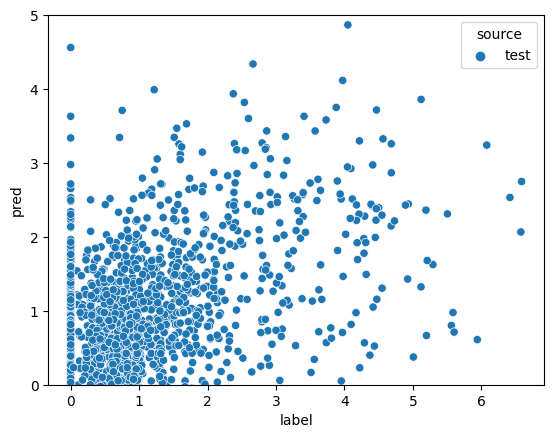

In [70]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.scatterplot(data=train_preds_df, x="label", y="pred", ax= ax, hue = 'source')
ax.set_ylim(0, 5)

plt.show()